# 08.Milestone Project 2 : PyTorch Paper Replicating

The goal of machine learning paper replicating is : turn a ML research paper into useable code.

In this notbook we're going to be relicating the vision transformer (ViT) architecture with PyTorch.

## 0. Get setup

Let's import code we've previously written + libraries

In [1]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.3.1+cu121
0.18.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 22.33 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

In [4]:
from pathlib import Path
from helper_functions import download_data
image_path = download_data(source ="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
              destination = "pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create DataSets and DataLoaders

In [6]:
import os
from torchvision import transforms

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32
IMG_SIZE = 224


manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

 # This comes from table 3 of the ViT paper

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                test_dir=test_dir,
                                                                                transform=manual_transforms,
                                                                                batch_size=BATCH_SIZE,
                                                                                num_workers=NUM_WORKERS)
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

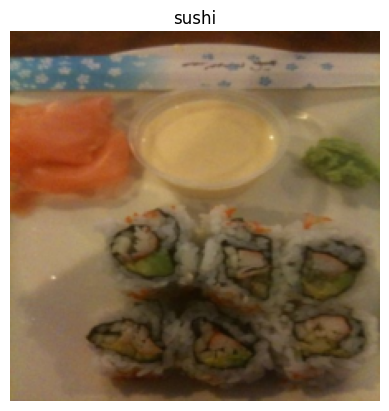

In [7]:
import matplotlib.pyplot as plt
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]

# Plot the image with matplotlib
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating ViT: Overview

Looking at a whole machine learning research paper can be imtimidating.

So in order to make it more unnderstandable, we can break it down into smaller pisces.

* **Inputs** - What goes into the model (in our case, image tensors)
* **Outputs** - What comes out of the model/layer/block? (in our case, we want the model to output image classification labels)
* **layers** - Takes an input, manipulates it with a function (for example could be self-attention)
* **Blocks** - A collection of layers.
* **Model** - A collection of blocks.

### 3.1 ViT Overview: Pieces of the puzzle

* Figure 1 : Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block
* Table 1/3: different hyperparameters for the architecture/training.
* Text



#### 3.2.1 Exploring Figure 1

Let's start by going through Figure 1 of the ViT Paper.

The main things we'll be paying attention to are:
1. **Layers** - takes an **input**, performs an operation or function on the input, produces an **output**.
2. **Blocks** - a collection of layers, which in turn also takes an **input** and produces an **output**.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs.png" width=900 alt="figure 1 from the original vision transformer paper"/>

*Figure 1 from the ViT Paper showcasing the different inputs, outputs, layers and blocks that create the architecture. Our goal will be to replicate each of these using PyTorch code.*

The ViT architecture is comprised of several stages:
* **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.
* **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an **embedding**, the benefit of using an embedding rather than just the image values is that an embedding is a *learnable* representation (typically in the form of a vector) of the image that can improve with training.
* **Norm** - This is short for "[Layer Normalization](https://paperswithcode.com/method/layer-normalization)" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer [`torch.nn.LayerNorm()`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
* **Multi-Head Attention** - This is a [Multi-Headed Self-Attention layer](https://paperswithcode.com/method/multi-head-attention) or "MSA" for short. You can create an MSA layer via the PyTorch layer [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).
* **MLP (or [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron))** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a `forward()` method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two [`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers with a [`torch.nn.GELU()`](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) non-linearity activation in between them (section 3.1) and a [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layer after each (Appendex B.1).
* **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
* **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

You might notice that many of the pieces of the ViT architecture can be created with existing PyTorch layers.

This is because of how PyTorch is designed, it's one of the main purposes of PyTorch to create reusable neural network layers for both researchers and machine learning practitioners.

> **Question:** Why not code everything from scratch?
>
> You could definitely do that by reproducing all of the math equations from the paper with custom PyTorch layers and that would certainly be an educative exercise, however, using pre-existing PyTorch layers is usually favoured as pre-existing layers have often been extensively tested and performance checked to make sure they run correctly and fast.

> **Note:** We're going to be focused on writing PyTorch code to create these layers. For the background on what each of these layers does, I'd suggest reading the ViT Paper in full or reading the linked resources for each layer.

Let's take Figure 1 and adapt it to our FoodVision Mini problem of classifying images of food into pizza, steak or sushi.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs-food-mini.png" width=900 alt="figure 1 from the original vision transformer paper adapted to work with food images, an image of pizza goes in and gets classified as 'pizza'"/>

*Figure 1 from the ViT Paper adapted for use with FoodVision Mini. An image of food goes in (pizza), the image gets turned into patches and then projected to an embedding. The embedding then travels through the various layers and blocks and (hopefully) the class "pizza" is returned.*

#### 3.2.2 Exploring the Four Equations

The next main part(s) of the ViT paper we're going to look at are the four equations in section 3.1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=650 alt="four mathematical equations from the vision transformer machine learning paper"/>

*These four equations represent the math behind the four major parts of the ViT architecture.*

Section 3.1 describes each of these (some of the text has been omitted for brevity, bolded text is mine):

| **Equation number** | **Description from ViT paper section 3.1** |
| ----- | ----- |
| 1 | ...The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a **trainable linear projection** (Eq. 1). We refer to the output of this projection as the **patch embeddings**... **Position embeddings** are added to the patch embeddings to retain positional information. We use standard **learnable 1D position embeddings**...|
| 2 | The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). **Layernorm (LN) is applied before every block**, and **residual connections after every block** (Wang et al., 2019; Baevski & Auli, 2019). |
| 3 | Same as equation 2. |
| 4 | Similar to BERT's [ class ] token, we **prepend a learnable embedding to the sequence of embedded patches** $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4)... |

Let's map these descriptions to the ViT architecture in Figure 1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-mapping-the-four-equations-to-figure-1.png" width=1000 alt="mapping the vision transformer paper figure 1 to the four equations listed in the paper"/>

*Connecting Figure 1 from the ViT paper to the four equations from section 3.1 describing the math behind each of the layers/blocks.*

There's a lot happening in the image above but following the coloured lines and arrows reveals the main concepts of the ViT architecture.

How about we break down each equation further (it will be our goal to recreate these with code)?

In all equations (except equation 4), "$\mathbf{z}$" is the raw output of a particular layer:

1. $\mathbf{z}_{0}$ is "z zero" (this is the output of the initial patch embedding layer).
2. $\mathbf{z}_{\ell}^{\prime}$ is "z of a particular layer *prime*" (or an intermediary value of z).
3. $\mathbf{z}_{\ell}$ is "z of a particular layer".

And $\mathbf{y}$ is the overall output of the architecture.

#### 3.2.3 Equation 1 overview

$$
\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}
$$

This equation deals with the class token, patch embedding and position embedding ($\mathbf{E}$ is for embedding) of the input image.

In vector form, the embedding might look something like:

```python
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]
```

Where each of the elements in the vector is learnable (their `requires_grad=True`).

#### 3.2.5 Equation 3 overview

$$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\end{aligned}
$$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN).

The addition on the end is showing the presence of a skip/residual connection.

We'll call this layer the "MLP block".

In pseudocode, this might look like:

```python
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

Notice the skip connection on the end (adding the input of the layers to the output of the layers).

#### 3.2.7 Exploring Table 1

The final piece of the ViT architecture puzzle we'll focus on (for now) is Table 1.

| Model | Layers | Hidden size $D$ | MLP size | Heads | Params |
| :--- | :---: | :---: | :---: | :---: | :---: |
| ViT-Base | 12 | 768 | 3072 | 12 | $86M$ |
| ViT-Large | 24 | 1024 | 4096 | 16 | $307M$ |
| ViT-Huge | 32 | 1280 | 5120 | 16 | $632M$ |

<div align=center>
    <i>Table 1: Details of Vision Transformer model variants. Source: <a href="https://arxiv.org/abs/2010.11929">ViT paper</a>.</i>
</div>
<br>

This table showcasing the various hyperparameters of each of the ViT architectures.

You can see the numbers gradually increase from ViT-Base to ViT-Huge.

We're going to focus on replicating ViT-Base (start small and scale up when necessary) but we'll be writing code that could easily scale up to the larger variants.

Breaking the hyperparameters down:
* **Layers** - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block)
* **Hidden size $D$** - This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more compute.
* **MLP size** - What are the number of hidden units in the MLP layers?
* **Heads** - How many heads are there in the Multi-Head Attention layers?
* **Params** - What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more compute. You'll notice even ViT-Base has far more parameters than any other model we've used so far.

We'll use these values as the hyperparameter settings for our ViT architecture.

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

I remember one of my machine learning engineer friends used to say "it's all about the embedding."

As in, if you can represent your data in a good, learnable way (as **embeddings are learnable representations**), chances are, a learning algorithm will be able to perform well on them.

With that being said, let's start by creating the class, position and patch embeddings for the ViT architecture.

We'll start with the **patch embedding**.

This means we'll be turning our input images in a sequence of patches and then embedding those patches.

Recall that an **embedding** is a learnable representation of some form and is often a vector.

The term learnable is important because this means the numerical representation of an input image (that the model sees) can be improved over time.

We'll begin by following the opening paragraph of section 3.1 of the ViT paper (bold mine):

> The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the **patch embeddings**.

And size we're dealing with image shapes, let's keep in mind the line from Table 3 of the ViT paper:

> Training resolution is **224**.

Let's break down the text above.

* $D$ is the size of the **patch embeddings**, different values for $D$ for various sized ViT models can be found in Table 1.
* The image starts as 2D with size ${H \times W \times C}$.
    * $(H, W)$ is the resolution of the original image (height, width).
    * $C$ is the number of channels.
* The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.
    * $(P, P)$ is the resolution of each image patch (**patch size**).
    * $N=H W / P^{2}$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-annotated.png" width=900 alt="mapping the vit architecture diagram positional and patch embeddings portion to the relative mathematical equation describing what's going on"/>

*Mapping the patch and position embedding portion of the ViT architecture from Figure 1 to Equation 1. The opening paragraph of section 3.1 describes the different input and output shapes of the patch embedding layer.*

In [8]:
 # Create example values
 height = 224
 width = 224
 color_channels = 3
 patch_size = 16

 # Calculate the number of patches

 number_of_patches = int((height * width) / patch_size ** 2)
 number_of_patches

196

In [9]:
# Inpur shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size ** 2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


### 4.2 Turning a single image into patches

Let's visualize, visualize, visualize...

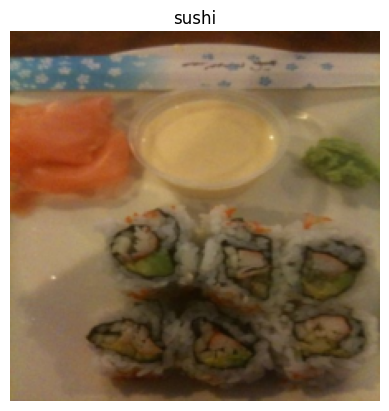

In [10]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off");

In [11]:
image.shape

torch.Size([3, 224, 224])

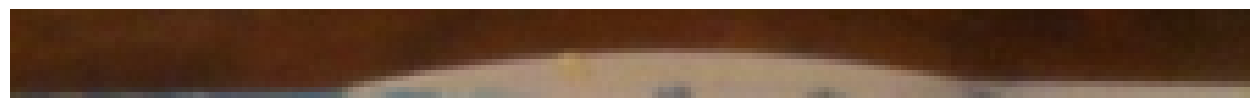

In [12]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])
plt.axis("off");

Number of patches per row: 14.0


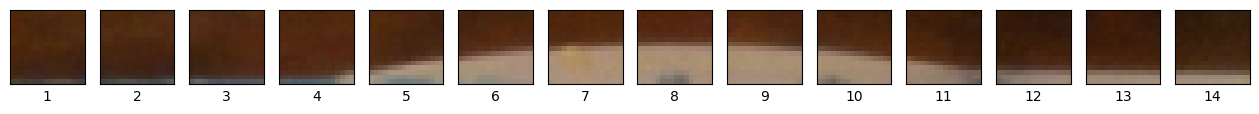

In [13]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # One column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))


# Iter thrugh number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i+1) # Set the patch label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


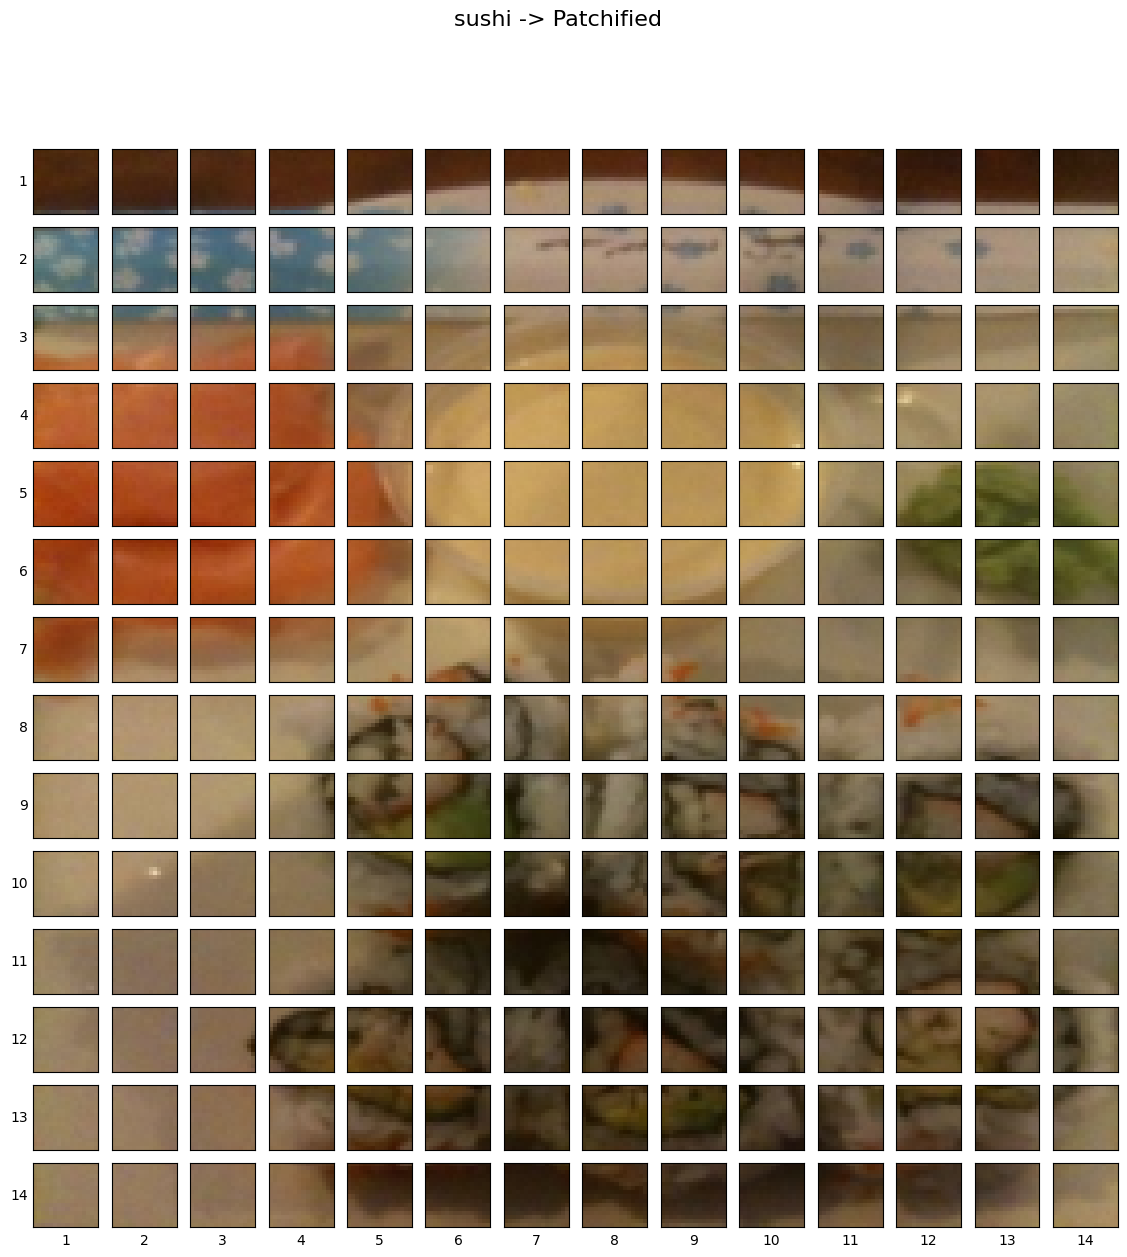

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### 4.3 Creating image patches and turning them into patch embeddings

Perhaps we could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride to `patch_size`

In [15]:
# Create Conv2d layer to turn image into patches of leranable feature maps (embeddings)
from torch import nn

patch_size = 16

# Create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # For color images
                   out_channels=768, # D size from Table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

conv2d


Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

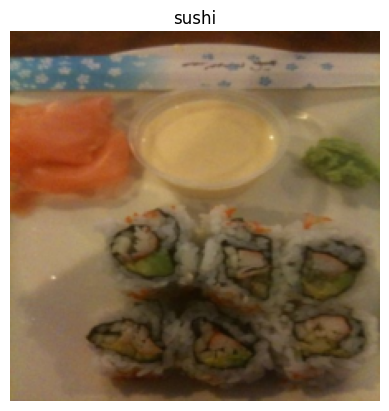

In [16]:
# Visualize a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off");

In [17]:
# Pass the image through the conv2d layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # Add a batch dimension -> (batch_size, C, H, W)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we've passed a single image to our `Conv2d` layer, it's shape is:

```python
torch.Size([1, 768, 14, 14])``` -> # [batch_size, embedding_dim, feature_map_height, feature_map_width]

In [18]:
image_out_of_conv.requires_grad

True

Showing random convolutional feature maps from indexes: [498, 543, 579, 343, 594]


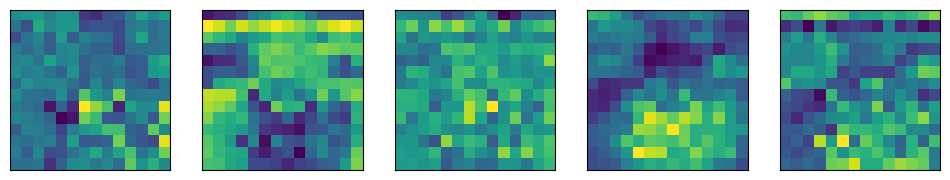

In [19]:
# Plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 768), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1,
                        ncols=5,
                        figsize=(12, 12))
# Plot the random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # Index on the output tesnor of the conv 2d layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # Remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
    axs[i].set(xticklabels=[], yticklabels=[],  xticks=[], yticks=[])



In [20]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map.shape

torch.Size([1, 14, 14])

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Right now we've got a series of Convolutional feature maps that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of the ViT Transformer Encoder.

Want: (batch_size, number_of_patches, embedding_dim)

In [21]:
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original Image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened feature maps shape: torch.Size([1, 768, 196])


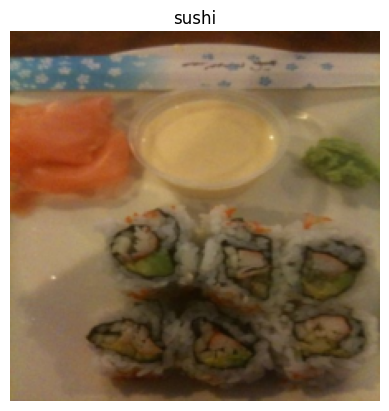

In [22]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off");
print(f"Original Image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened feature maps shape: {image_out_of_conv_flattened.shape}")


In [23]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


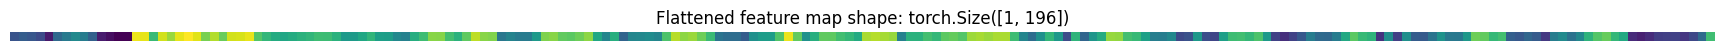

In [24]:
# Get a single flattened feature map
single_flattened_feature_map  = image_out_of_conv_flattened_permuted[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis("off");

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:
1. Create a class called `PatchEmbedding` That inherits from `nn.Module`
2. Initialize with appropriate hyperparameters, such as channels, embedding dimensions, patch size.
3. Create a layer to turn an image into embedding patches using `nn.Conv2d()`
4. Create a layer to Flatten the feature maps of the output of the layer in step 3.
5. Define a `forward()` that defines the forward computation (e.g. pass through  layer from 3 and 4).
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [25]:
class PatchEmbedding(nn.Module):
    # Initialize the layers with appropriate hyperparameters
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        self.patch_size = patch_size
        # Create a layer to turn an image into embedded patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        # Create a layer to flatten the feature maps
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
    # Define a forward method to define the forward computations
    def forward(self, x):
        # Create assertion to check that inputs are in the correct resolution
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image_size: {image_resolution} and patch_size: {self.patch_size}"
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # Make sure the returned sequence embedding are in the right order (batch_size, number_of_patches, embedding_dimension)

        return x_flattened.permute(0, 2, 1)


In [26]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)
# Pass a single image into patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output embedding size: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output embedding size: torch.Size([1, 196, 768])


In [27]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)
# patchify(rand_image_tensor_bad).shape
patchify(rand_image_tensor).shape


torch.Size([1, 196, 768])

### 4.6 Creating the class token embedding

Want to prepend a learnable class token to the start of the patch embedding.

In [28]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [29]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape


torch.Size([1, 1, 768])

In [30]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [31]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # Number of patches dimension

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches,embedding_dim )")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2332,  0.0453, -0.1040,  ...,  0.0967, -0.0974,  0.0600],
         [-0.2606,  0.0607, -0.0953,  ...,  0.0935, -0.0876,  0.0571],
         ...,
         [-0.2745,  0.0205, -0.1321,  ...,  0.1757, -0.1011,  0.1285],
         [-0.4052,  0.1081, -0.1517,  ...,  0.3164, -0.1794,  0.1142],
         [-0.5632,  0.1053, -0.1437,  ...,  0.3965, -0.2449,  0.2157]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches,embedding_dim )


### 4.7 Creating the position embedding

Want to: create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings.

In [32]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.2332,  0.0453, -0.1040,  ...,  0.0967, -0.0974,  0.0600],
          [-0.2606,  0.0607, -0.0953,  ...,  0.0935, -0.0876,  0.0571],
          ...,
          [-0.2745,  0.0205, -0.1321,  ...,  0.1757, -0.1011,  0.1285],
          [-0.4052,  0.1081, -0.1517,  ...,  0.3164, -0.1794,  0.1142],
          [-0.5632,  0.1053, -0.1437,  ...,  0.3965, -0.2449,  0.2157]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [33]:
# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                            number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [34]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7668, 1.0453, 0.8960,  ..., 1.0967, 0.9026, 1.0600],
         [0.7394, 1.0607, 0.9047,  ..., 1.0935, 0.9124, 1.0571],
         ...,
         [0.7255, 1.0205, 0.8679,  ..., 1.1757, 0.8989, 1.1285],
         [0.5948, 1.1081, 0.8483,  ..., 1.3164, 0.8206, 1.1142],
         [0.4368, 1.1053, 0.8563,  ..., 1.3965, 0.7551, 1.2157]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


### 4.8 Putting it all together: From image to embedding

we've written code to turn an image in a flattened sequence of patch embeddings.

Now Let's see it all in one cell!

In [35]:
# Set the seeds
set_seeds(42)

# 1. Set the patch size
patch_size = 16

# 2. Print shapes of the original image and get the image dimensions
print(f"image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"input image shape : {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass input image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"patch embedding shape : {patch_embedding.shape}")

# 6. Create a class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad = True) # Make sure it's learnable
print(f"class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"patch embedding with cclass token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"patch and position embedding shape : {patch_and_position_embedding.shape}")

image tensor shape: torch.Size([3, 224, 224])
input image shape : torch.Size([1, 3, 224, 224])
patch embedding shape : torch.Size([1, 196, 768])
class token embedding shape: torch.Size([1, 1, 768])
patch embedding with cclass token shape: torch.Size([1, 197, 768])
patch and position embedding shape : torch.Size([1, 197, 768])


## Equation 2: Multihead Self-Attention (MSA Block)

* Multihead sekf-attention: which part of a sequence should pay the most attention to itself?
    * In our case we have a series of embedded image patches, which patch significantly relates to another patch.
    * We want our ViT to learn this relationship/representation.
    * Normalization = make everything have the same mean and same standard deviation.
    * in Pytorch - `torch.nn.LayerNorm()`

* normmalizes values over D dimension , in our case, the $D$ dimension is the embedding dimension.

    * When we normalize along the embedding dimension, it's like making all of the stairs in a staircase the same size.


In [36]:
import torch
from torch import nn

In [37]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """Creates a multihead self-attention block (MSA Block).
    """
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D (embedding dimension)
                 num_heads:int=12, # Heads from Table 1
                 attn_dropout:int=0):
        super().__init__()
        # Create the norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the multihead attention layer (MSA)
        self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                    num_heads = num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # is the batch first ? (batch, seq, feature) -> (batch, num_patches, embedding_dim)
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [38]:
# Create an instance of our MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)
# Pass the patch and position image embedding sequence through our MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [39]:
# Shapes stay the same but the values change
patched_image_through_msa_block , patch_and_position_embedding

(tensor([[[-0.1954, -0.2426,  0.0757,  ..., -0.4214,  0.8969, -0.4613],
          [-0.1878, -0.2401,  0.0759,  ..., -0.4193,  0.9051, -0.4705],
          [-0.1877, -0.2390,  0.0770,  ..., -0.4188,  0.9042, -0.4704],
          ...,
          [-0.1883, -0.2371,  0.0791,  ..., -0.4203,  0.9052, -0.4714],
          [-0.1884, -0.2383,  0.0787,  ..., -0.4199,  0.9060, -0.4726],
          [-0.1877, -0.2375,  0.0777,  ..., -0.4215,  0.9066, -0.4725]]],
        grad_fn=<TransposeBackward0>),
 tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.7668, 1.0453, 0.8960,  ..., 1.0967, 0.9026, 1.0600],
          [0.7394, 1.0607, 0.9047,  ..., 1.0935, 0.9124, 1.0571],
          ...,
          [0.7255, 1.0205, 0.8679,  ..., 1.1757, 0.8989, 1.1285],
          [0.5948, 1.1081, 0.8483,  ..., 1.3164, 0.8206, 1.1142],
          [0.4368, 1.1053, 0.8563,  ..., 1.3965, 0.7551, 1.2157]]],
        grad_fn=<AddBackward0>))

## 6. Equation 3: Multilayer Perceptron (MLP Block)

* **MLP** = The MLP contains two layers with a GELU non-Linearity (section 3.1)
    * MLP hidden number of units = MLP size in Table 1.
    * MLP = a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer.
    * Layers can mean : fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. in PyTorch they're often called `torch.nn.Linear()` and in TensorFlow they might be called `tf.keras.layers.Dense()`.
    * Read about **GELU** in PyTorch.

In pseudocode:

```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```

In [40]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:int=0.1): # Value of Dropout is available in Table 3
        super().__init__()

        # Create the norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the MLP
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x
        # return self.mlp(self.layer_norm(x))

In [41]:
# Create an instance of mlp block
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)
# Pass output the msa block through mlp block
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of mlp block: {patched_image_through_msa_block.shape}")
print(f"Output shape of mlp block: {patched_image_through_mlp_block.shape}")

Input shape of mlp block: torch.Size([1, 197, 768])
Output shape of mlp block: torch.Size([1, 197, 768])


In [42]:
patched_image_through_mlp_block, patched_image_through_msa_block

(tensor([[[-5.1165e-02, -2.0632e-02,  2.0178e-01,  ...,  0.0000e+00,
           -1.7564e-01,  2.1702e-01],
          [-1.0571e-01, -1.3629e-01,  3.0932e-01,  ..., -8.9387e-02,
           -1.4377e-01,  2.3010e-01],
          [ 3.1658e-04, -6.2420e-02,  3.2899e-01,  ..., -0.0000e+00,
           -2.1290e-01,  2.1651e-01],
          ...,
          [-1.8759e-01, -2.1949e-02,  3.1773e-01,  ...,  1.1815e-01,
           -2.2986e-01,  3.1164e-01],
          [-1.1356e-01,  4.1357e-02,  0.0000e+00,  ...,  5.2432e-02,
           -1.9832e-01,  1.0080e-01],
          [-6.6120e-02, -3.6331e-02,  2.7814e-01,  ..., -1.1304e-01,
           -1.7826e-01,  2.0185e-01]]], grad_fn=<MulBackward0>),
 tensor([[[-0.1954, -0.2426,  0.0757,  ..., -0.4214,  0.8969, -0.4613],
          [-0.1878, -0.2401,  0.0759,  ..., -0.4193,  0.9051, -0.4705],
          [-0.1877, -0.2390,  0.0770,  ..., -0.4188,  0.9042, -0.4704],
          ...,
          [-0.1883, -0.2371,  0.0791,  ..., -0.4203,  0.9052, -0.4714],
          [-0

## 7. Create the Transformer Encoder

The Transformer Encorder is a combination of MSA and MLP. (equation2 and equation 3)

And there are residual connections between each block.

* Encoder = turn a sequence into learnable representation.
* Decoder = go from learn representation back to some sort of sequence.
* Residual connections = add a layer(s) input to its subsequent output, this enables the creation of deeper networks (prevents weights from getting too small)

In pseudocode:
```python
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

### 7.1 Create a custom TransformerEncoderBlock

In [43]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:int=0.1,
                 attn_dropout:int=0):
        super().__init__()

        # Create MSA Block
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                        num_heads=num_heads,
                                                        attn_dropout=attn_dropout)
        # Create the MLP Block
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)
    def forward(self, x):
        x = self.msa_block(x) + x # Residual/skip connection for equation 2
        x = self.mlp_block(x) + x # Residual/skip connection for equation 3
        return x

In [44]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()
from torchinfo import summary

# Get a summmary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (patch_size, num_patches, embedding_dim)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a Transformer Encoder layer with in-built PyTorch layers

In [45]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # embedding_dim
                                                             nhead=12, # num_heads
                                                             dim_feedforward=3072, # mlp_size
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [46]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (patch_size, num_patches, embedding_dim)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## 8. Putting it all together to create ViT

In [47]:
# Create a ViT Class
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:int=0,
                 mlp_dropout:int=0.1,
                 embedding_dropout:int=0.1,
                 num_classes:int=1000):
        super().__init__()

        # Make an assertion that the image size is compatible with the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch_size, image:{img_size}, patch size:{patch_size}"

        # calculate the number of patches (height * width / patch ^ 2)
        self.num_patches = (img_size * img_size) // patch_size ** 2

        # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

        # Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # Create the TransformerEncoderBlock
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                           num_heads=num_heads,
                                                                           mlp_size=mlp_size,
                                                                           mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        # Create Classifier Head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )
    def forward(self, x):
        #Get the batch_size
        batch_size = x.shape[0]

        # Create the class token embedding and expand it to match the batch_size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimensions

        # Create the patch embedding (equation 1)
        x = self.patch_embedding(x)

        # Concat class token embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # Add position embedding to class token and patch embedding
        x = self.position_embedding + x

        # Apply dropout to patch_embeddings
        x = self.embedding_dropout(x)

        # Pass position and patch embedding to TransformerEncoder
        x = self.transformer_encoder(x)

        # Put 0th index logit through the classifier (equation 4)
        x = self.classifier(x[:, 0])

        return x

In [48]:
set_seeds()
# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of vit architecture with the number of classes
vit = ViT(num_classes=len(class_names))

#  Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of our ViT model

In [49]:
from torchinfo import summary
summary(model=ViT(num_classes=len(class_names)),
        input_size=(1, 3, 224, 224), # (patch_size, num_patches, embedding_dim)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## 9. Setting up taining code for our custom ViT

### 9.1 Creatin an optimizer

The paper states it uses the Adam optimizer (section 4)
with $B1$ value of 0.9 and $B2$ value of 0.999 (defaults) and a weight decay of 0.1.

In [50]:
optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

### 9.2 Creating a loss function

In [51]:
loss_fn = torch.nn.CrossEntropyLoss()

### 9.3 Training our ViT model

In [53]:
from going_modular.going_modular import engine
set_seeds()
optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)
loss_fn = torch.nn.CrossEntropyLoss()
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=3,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

### 9.4 What our training setup is missing

The main things our training implementation is missing:
Prevent underfitting:
* Data - our setup uses far less data (225 vs milions)

Prevent overfitting:
* Learning rate warup - start with a low learning rate and increase to a base LR
* Learning rate decay - as your model gets closer to convergence, start to lower the LR.
* Gradient clipping - prevent gradients from getting too big

### 9.5 plotting loss curves for our model

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

## 10. Using a pretrained ViT from `torchvision.models()`

Generally, in deep learning if you can use a pretrained model from a large dataset on your own problem, it's often a good place to start.

Transfer learning often achives great results with little data.

In [55]:
import torch
import torchvision
from torchvision import models, datasets
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [66]:
# Get pretrained weights
pretrained_vit_weights = models.ViT_B_16_Weights.DEFAULT

# Setup a ViT model instance with pretrained weights
pretrained_vit = models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad=False

# Update the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features = 768, out_features = len(class_names)).to(device)

In [67]:
from torchinfo import summary
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (patch_size, num_patches, embedding_dim)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.3 Preparing data for the pretrained ViT model

When using a pretrained model, you want to make sure your data is formatted in the same way that the model was trained on.

In [68]:
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [69]:
# Setup some dataloaders
from going_modular.going_modular import data_setup
import os
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32,
                                                                                                     num_workers=os.cpu_count())

### 10.4 Train feature extractor ViT model

In [72]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained vit
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=2,
                                      device=device)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977


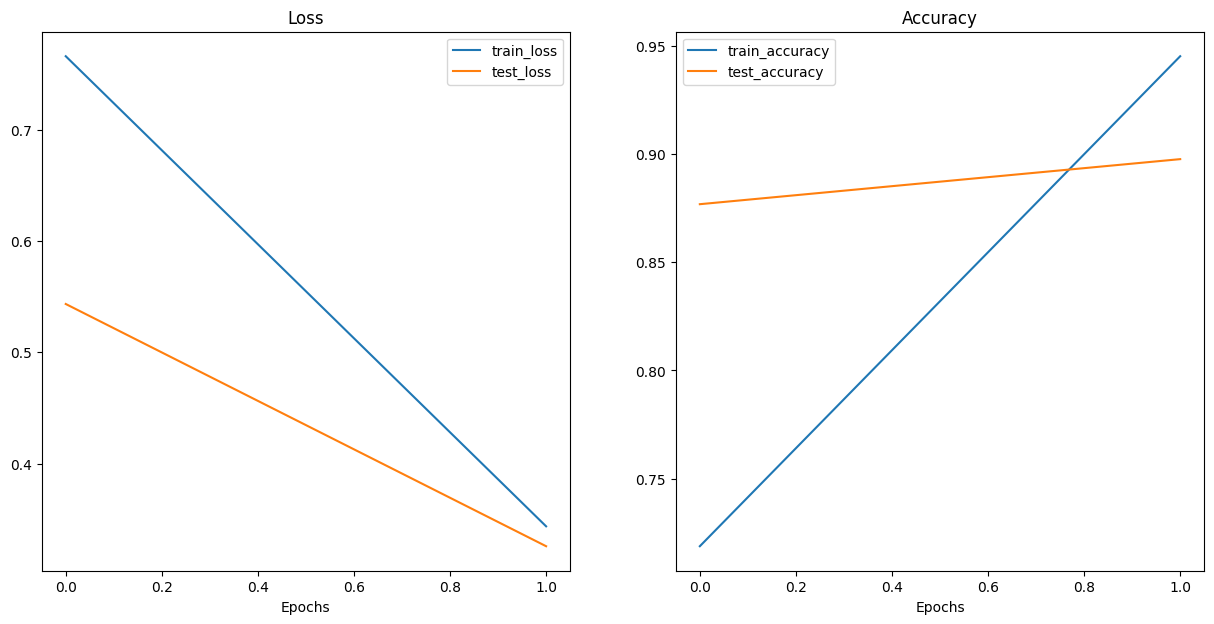

In [73]:
plot_loss_curves(pretrained_vit_results)

In [74]:
pretrained_vit.state_dict

<bound method Module.state_dict of VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_2): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_3): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_4): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_5): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=Fa

### 10.6 Save our best performing ViT model

Now we've got a model that performs quite well how about we save it to file and check it's file size

We want to check the file size because if we wanted to deploy our model to a website/mobile APP, we may have limitations of the size of the model we can deploy

In [76]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractore_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractore_pizza_steak_sushi.pth


In [79]:
from pathlib import Path

# Get the model size in bytes then we can convert it to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractore_pizza_steak_sushi.pth").stat().st_size // (1024 * 1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


## 11. Predicitong on a custom image

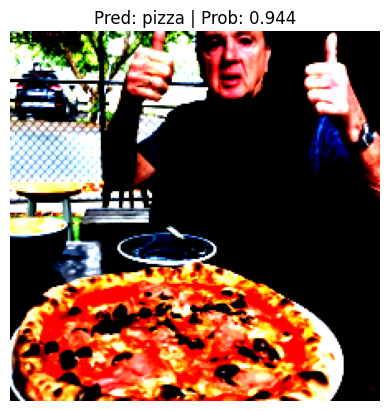

In [81]:
from helper_functions import pred_and_plot_image
pred_and_plot_image(model=pretrained_vit,
                    image_path="/content/04-pizza-dad (1).jpeg",
                    class_names=class_names,
                    transform=vit_transforms,
                    device=device)